In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import textwrap

In [3]:
# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
# Создаем копию с нужными столбцами
df = pd.read_csv('sensor_events.csv', sep=';')
analysis_data = df[['datetime', 'hour', 'equipment_number', 'event_description']].copy()

# Преобразуем datetime
analysis_data['datetime'] = pd.to_datetime(analysis_data['datetime'])

# Добавляем дополнительные колонки для анализа
analysis_data['date'] = analysis_data['datetime'].dt.date
analysis_data['day_of_week'] = analysis_data['datetime'].dt.day_name()
analysis_data['day_of_month'] = analysis_data['datetime'].dt.day

print(f"Всего аварий датчиков: {len(analysis_data)}")
print(f"Период данных: {analysis_data['datetime'].min()} - {analysis_data['datetime'].max()}")
print(f"Уникального оборудования: {analysis_data['equipment_number'].nunique()}")

Всего аварий датчиков: 107
Период данных: 2025-11-11 10:08:26 - 2025-11-25 22:32:03
Уникального оборудования: 25


 Топ-10 событий с датчиками:
    1. [ 34] сработал датчик подпора
    2. [ 33] сработал датчик скорости
    3. [ 18] сработал датчик натяжения цепи
    4. [ 10] сработал датчик подпора (низ)
    5. [  6] сработал датчик схода
    6. [  4] сработал датчик схода (верх)
    7. [  1] сработал датчик подпора (верх)
    8. [  1] сработал датчик схода (низ)


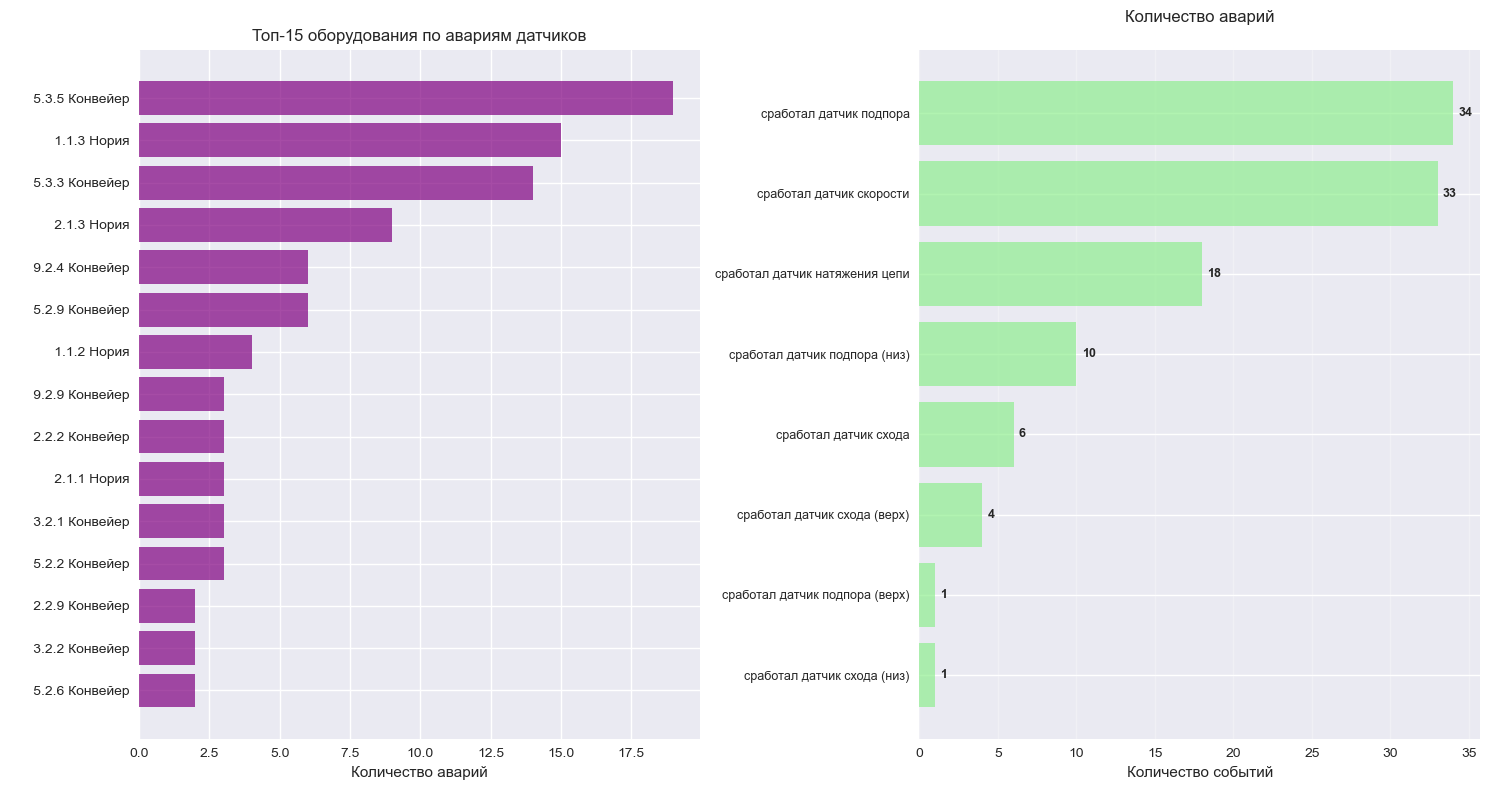

In [5]:
# График 5: Топ оборудования по авариям
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
top_equipment = analysis_data['equipment_number'].value_counts().head(15)
plt.barh(range(len(top_equipment)), top_equipment.values, color='purple', alpha=0.7)
plt.yticks(range(len(top_equipment)), top_equipment.index)
plt.title('Топ-15 оборудования по авариям датчиков')
plt.xlabel('Количество аварий')
plt.gca().invert_yaxis()

# График 6: Улучшенная горизонтальная бар-диаграмма
plt.subplot(1, 2, 2)
event_types = analysis_data['event_description'].value_counts().head(20)

# Создаем укороченные labels для оси Y
short_labels = []
for label in event_types.index:
    words = label.split()
    if len(words) > 4:  # если больше 4 слов - обрезаем
        short_label = ' '.join(words[:4]) + '...'
    else:
        short_label = label
    short_labels.append(short_label)

y_pos = range(len(event_types))
bars = plt.barh(y_pos, event_types.values, color='lightgreen', alpha=0.7, height=0.8)
plt.yticks(y_pos, short_labels, fontsize=9)  # уменьшаем шрифт
plt.xlabel('Количество событий')
plt.title('Количество аварий', pad=20)
plt.gca().invert_yaxis()

# Добавляем значения
for i, v in enumerate(event_types.values):
    plt.text(v + max(event_types.values) * 0.01, i, str(v), 
             va='center', fontweight='bold', fontsize=9)

# Добавляем сетку для лучшей читаемости
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()

print(" Топ-10 событий с датчиками:")
for i, (event, count) in enumerate(event_types.items(), 1):
    print(f"   {i:2d}. [{count:>3}] {event}")


plt.tight_layout()
plt.show()

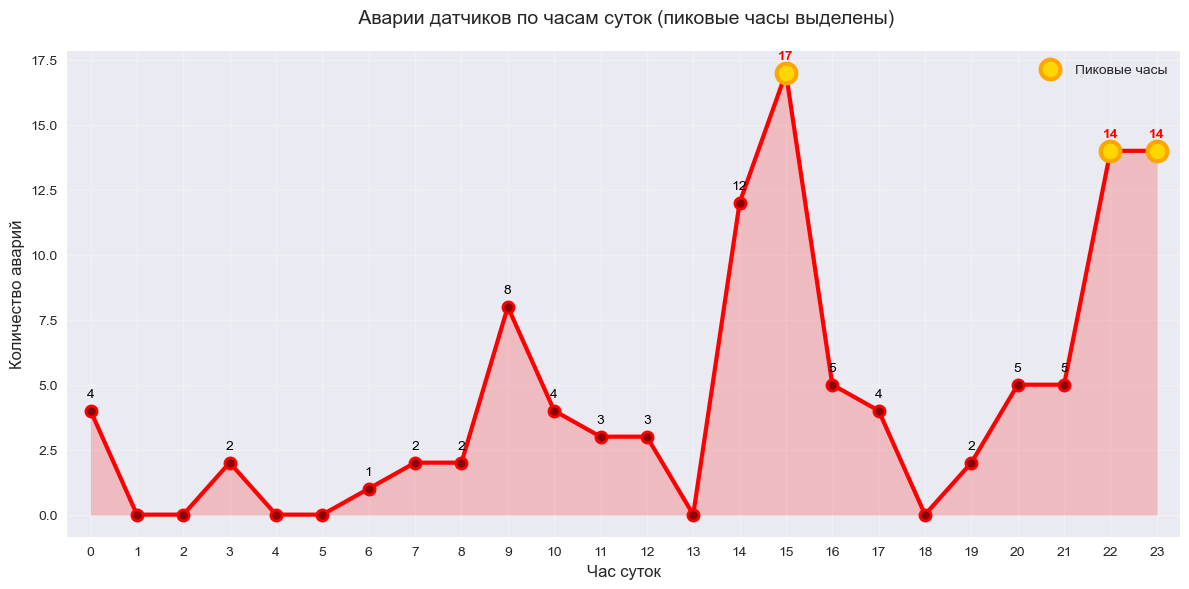

 ПИКОВЫЕ ЧАСЫ АВАРИЙ:
   1. 🕐 15:00 - 17 аварий (15.9%)
   2. 🕐 22:00 - 14 аварий (13.1%)
   3. 🕐 23:00 - 14 аварий (13.1%)


In [6]:
# Линейный график с выделением пиковых часов
plt.figure(figsize=(12, 6))

hourly_failures = analysis_data['hour'].value_counts().sort_index()
all_hours = pd.Series(index=range(0, 24), data=0)
hourly_failures = hourly_failures.reindex(all_hours.index, fill_value=0)

# Находим пиковые часы
peak_hours = hourly_failures.nlargest(3)

plt.plot(hourly_failures.index, hourly_failures.values, 
         marker='o', linewidth=3, markersize=8, color='red', 
         markerfacecolor='darkred', markeredgewidth=2)

# Выделяем пиковые часы
for hour in peak_hours.index:
    plt.scatter(hour, peak_hours[hour], 
                s=200, color='gold', edgecolors='orange', 
                linewidth=3, zorder=5, label='Пиковые часы' if hour == peak_hours.index[0] else "")

plt.fill_between(hourly_failures.index, hourly_failures.values, 
                 alpha=0.2, color='red')

plt.title(' Аварии датчиков по часам суток (пиковые часы выделены)', fontsize=14, pad=20)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество аварий', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.xlim(-0.5, 23.5)

# Подписи для всех часов
for hour, count in hourly_failures.items():
    if count > 0:
        color = 'red' if hour in peak_hours.index else 'black'
        weight = 'bold' if hour in peak_hours.index else 'normal'
        plt.annotate(f'{count}', (hour, count), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center', 
                     fontweight=weight,
                     color=color,
                     fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()

print(" ПИКОВЫЕ ЧАСЫ АВАРИЙ:")
for i, (hour, count) in enumerate(peak_hours.items(), 1):
    percentage = (count / len(analysis_data)) * 100
    print(f"   {i}. 🕐 {hour:02d}:00 - {count} аварий ({percentage:.1f}%)")

Text(0, 0.5, 'Количество аварий')

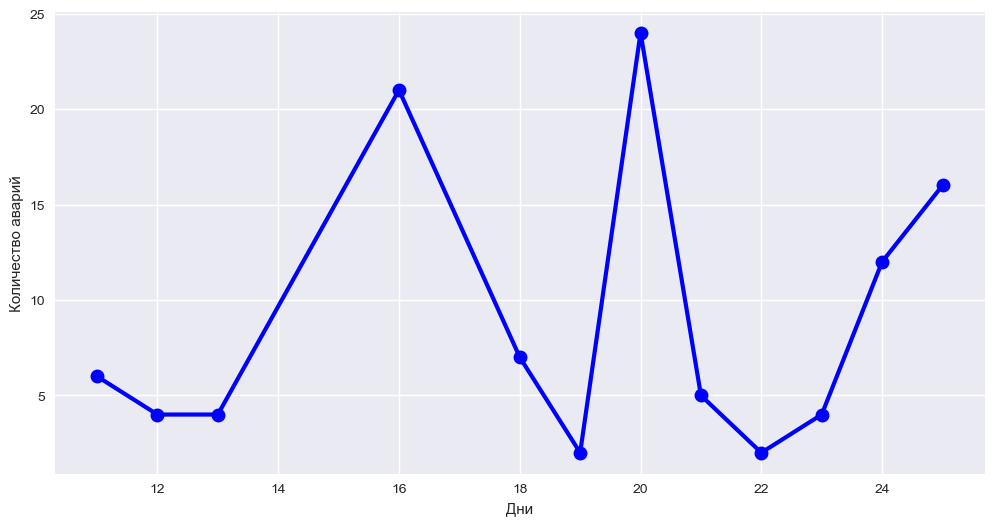

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(analysis_data['day_of_month'].value_counts().sort_index(), 
         marker='o', linewidth=3, markersize=8, color='blue', 
         markerfacecolor='blue', markeredgewidth=2,)
plt.xlabel('Дни')
plt.ylabel('Количество аварий')



